In [39]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Nota previa en cuanto a los datos climatológicos

A continuación se especifica la justificación de la extracción de datos climatológicos de AEMET

In [43]:
# Cargar el dataset y mostrar las primeras filas
bdif = pd.read_excel("bdif_geo_clim_fwi_pob.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,diastormenta,diasultimalluvia,tempmaxima,humrelativa,velocidadviento,...,indicativo,prec,tmax,dir,velmedia,racha,sol,hrmedia,fwi,poblacion
0,1974020249,1974,11,2,0.0,NaN,NaN,10.0,75.0,30.0,...,8175,0.0,17.0,29.0,6.1,11.9,9.5,56.0,12.101361,2117.457786
1,1974020374,1974,11,2,0.0,NaN,NaN,NaN,NaN,NaN,...,8175,0.0,26.6,18.0,6.4,13.1,10.9,53.0,69.039001,26076.005568
2,1974020459,1974,11,46,0.0,NaN,NaN,NaN,NaN,NaN,...,8414A,0.0,23.0,9.0,3.6,11.1,3.3,71.0,11.837668,3790.498405
3,1974022274,1974,11,2,0.0,NaN,NaN,NaN,NaN,NaN,...,8175,0.0,28.0,NaN,5.0,NaN,8.9,63.0,42.358257,1133.070631
4,1974022457,1974,11,2,0.0,NaN,NaN,NaN,NaN,NaN,...,8175,0.0,23.2,NaN,4.7,NaN,9.3,45.0,15.454229,513.556146


In [44]:
# Cargamos solo los datos hasta 2016 incluido que es hasta donde esta consolidada la base de datos del EGIF
bdif = bdif[bdif['año'] <= 2016]

In [45]:
bdif.shape

(570372, 35)

In [46]:
# Visualización de atributos
bdif.columns

Index(['parte', 'año', 'cod_com', 'cod_prov', 'probignicion', 'diastormenta',
       'diasultimalluvia', 'tempmaxima', 'humrelativa', 'velocidadviento',
       'direccionviento', 'detectadopor', 'deteccion', 'combustible', 'fuego',
       'lugar', 'mes', 'dia', 'id_rel', 'provincia', 'superficie', 'altitud',
       'areaquemada', 'lon', 'lat', 'indicativo', 'prec', 'tmax', 'dir',
       'velmedia', 'racha', 'sol', 'hrmedia', 'fwi', 'poblacion'],
      dtype='object')

### Datos faltantes

In [47]:
# Nos centramos en buscar los valores faltantes de las condiciones climáticas
faltantes = bdif[['diastormenta','diasultimalluvia','tempmaxima','humrelativa','velocidadviento','direccionviento']].isnull().sum()

In [48]:
# Lo pasamos a un dataframe
faltantes = pd.DataFrame({
    'Variable': faltantes.index,
    'Faltantes': faltantes.values,
    'Porcentaje': (faltantes.values / len(bdif)) * 100
})
faltantes = faltantes[faltantes['Faltantes']>0]
faltantes

,Variable,Faltantes,Porcentaje
0,diastormenta,561110,98.376147
1,diasultimalluvia,364452,63.897246
2,tempmaxima,291494,51.105945
3,humrelativa,296594,52.000098
4,velocidadviento,311314,54.580870
5,direccionviento,369835,64.841016


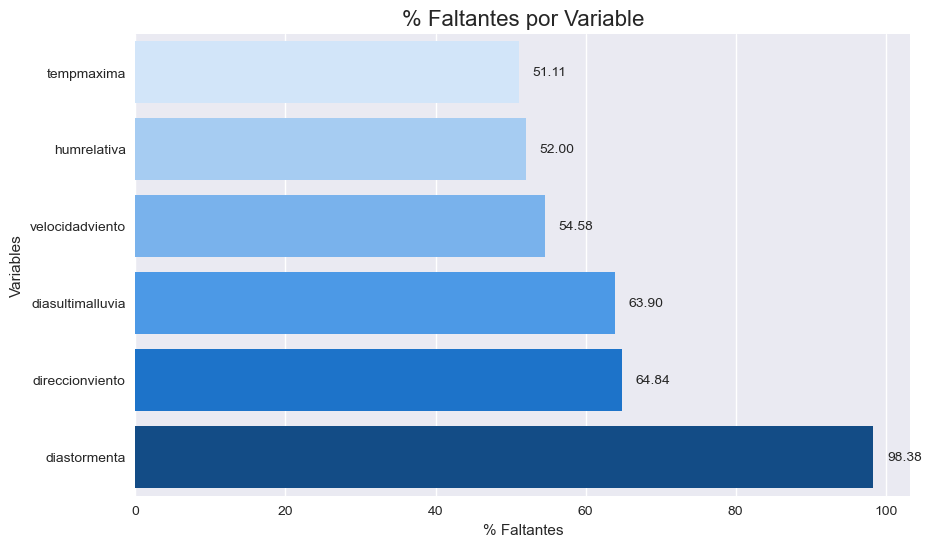

In [49]:
# Lo pasamos a un grafico de barras para que sea más visual
# Ordenamos el dataframe
faltantes = faltantes.sort_values(by='Porcentaje')

# Estilo
plt.style.use("seaborn-v0_8")

# Paleta de colores
colors = ['#cce5ff', '#99ccff', '#66b2ff', '#3399ff', '#0073e6', '#004c99']

# Gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=faltantes, x='Porcentaje', y='Variable', hue='Variable', palette=colors, legend=False)

# Info de los porcentajes
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.2f'),
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center',
                xytext=(10, 0), textcoords='offset points')

# Mostramos el gráfico
plt.title('% Faltantes por Variable', fontsize=16)
plt.xlabel('% Faltantes')
plt.ylabel('Variables')
plt.show()

Hay porcentajes muy altos de datos faltantes donde llegaríamos a perder la mitad de los registros del dataset.

### Aspecto de los boxplot con datos atípicos

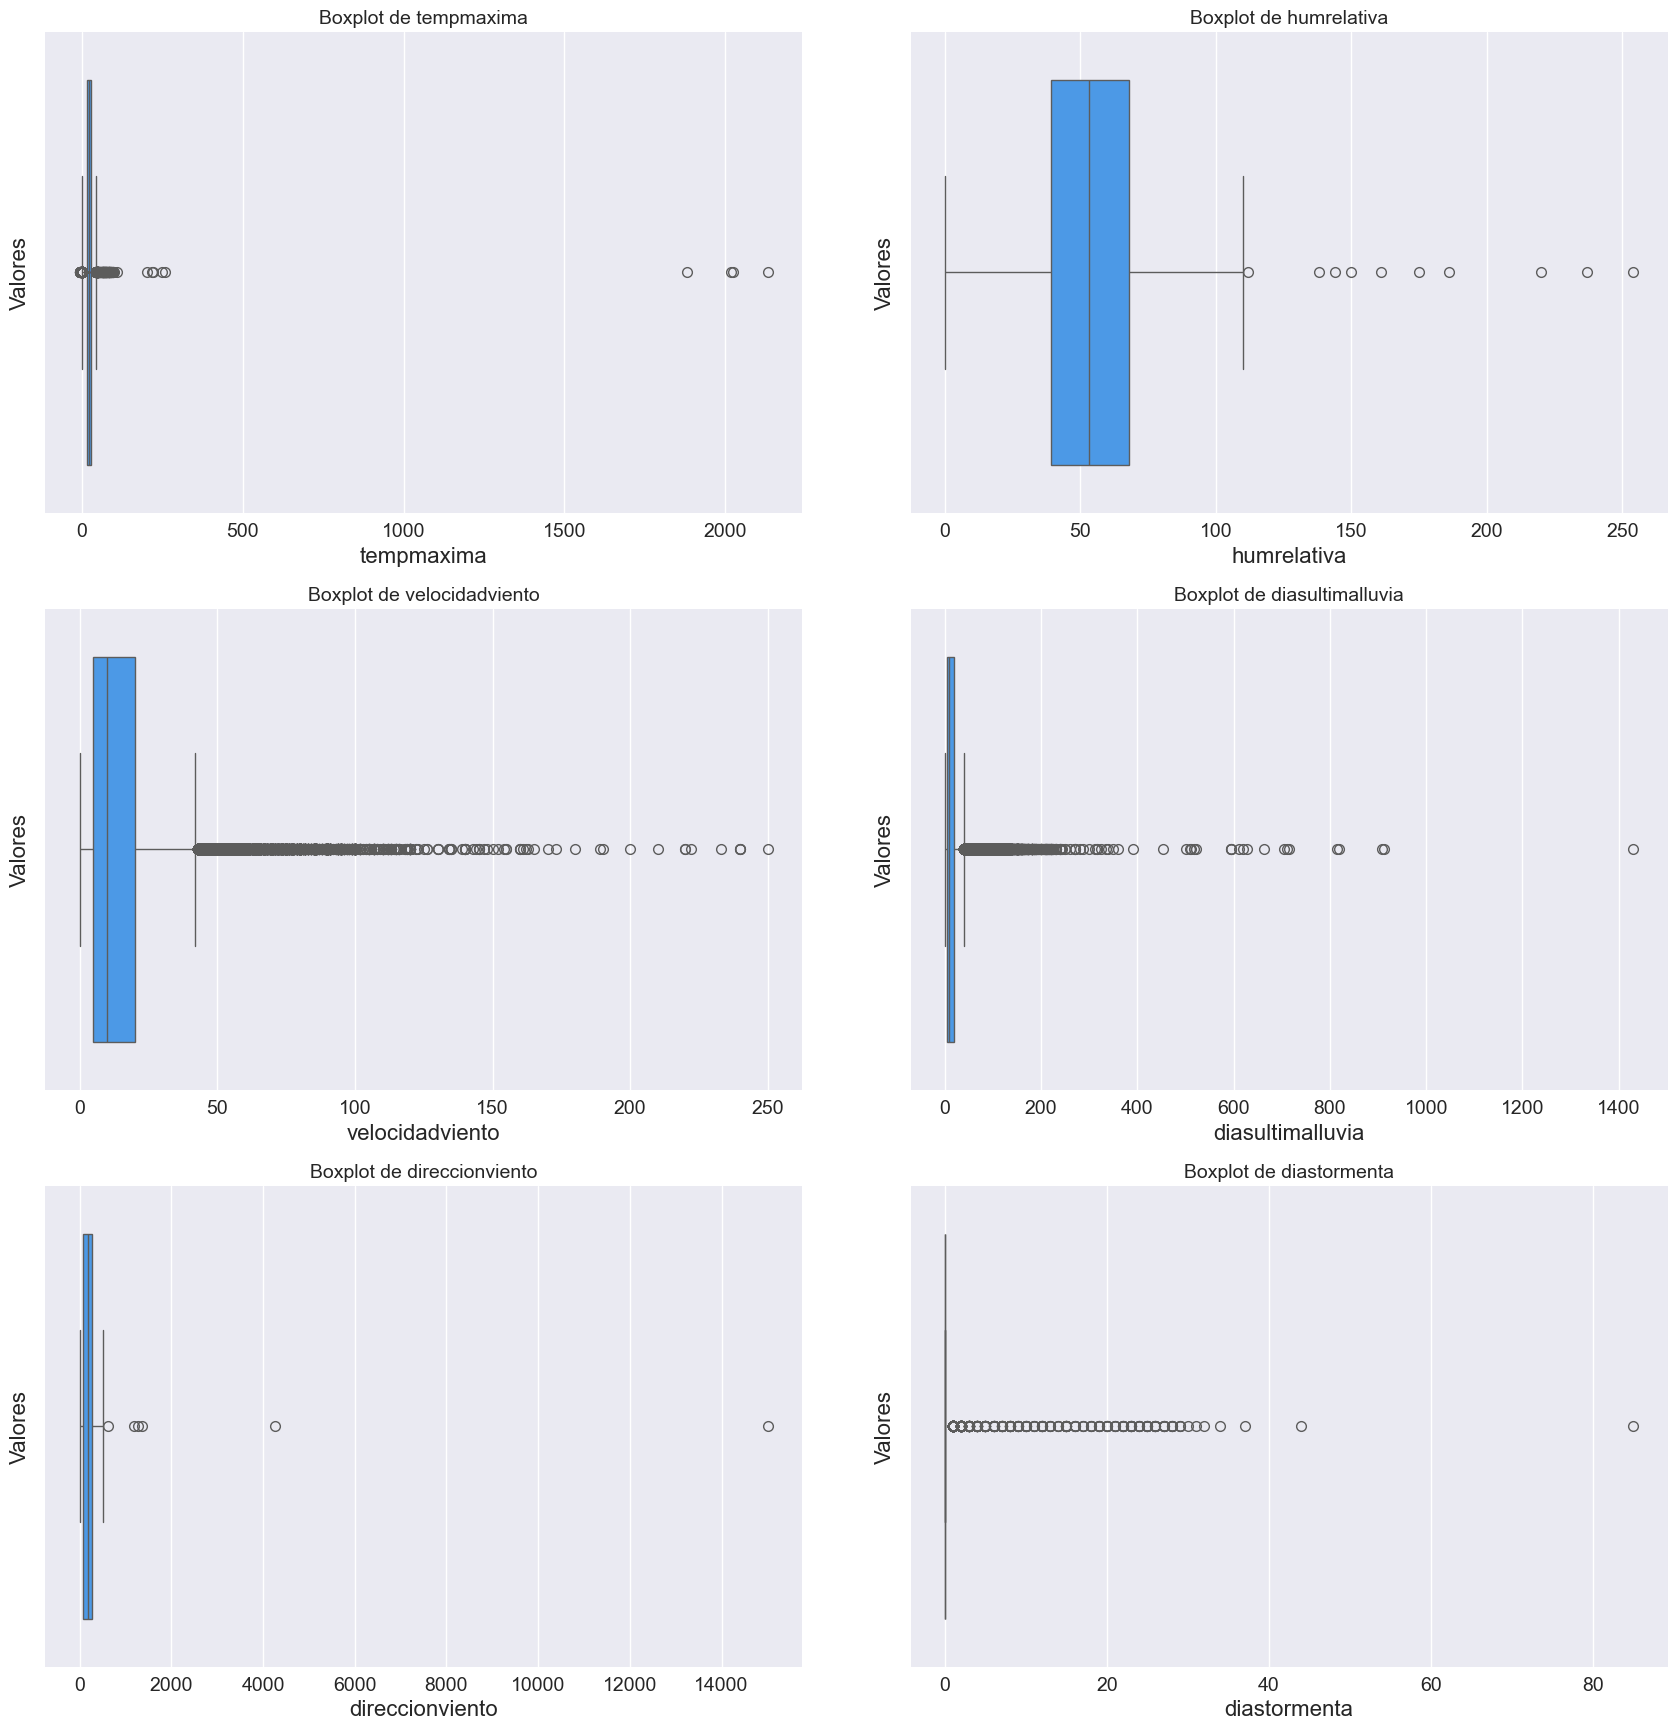

In [50]:
# Seleccionamos las columnas que queremos mostrar
columnas = ['tempmaxima', 'humrelativa', 'velocidadviento', 'diasultimalluvia', 'direccionviento', 'diastormenta']

# Creamos una plantilla de 3 filas x 2 columnas
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.tight_layout(pad=5.0)

# Recorrer las columnas y vamos mostrando gráfico a gráfico
for i, col in enumerate(columnas):
    ax = axes[i//2, i%2]  # Posición
    sns.boxplot(x=bdif[col], color='#3399ff', ax=ax)  # Boxplot en apaisado
    ax.set_title(f'Boxplot de {col}', fontsize=14)  # Título
    ax.set_xlabel(col, fontsize=16)  # Titulo eje x
    ax.set_ylabel('Valores', fontsize=16)  # Titulo eje y
    ax.tick_params(axis='both', which='major', labelsize=14)  # Ajustar letra ejes

# Mostramos el gráfico
plt.show()

Vemos que hay bastantes valores atípicos, días de últimas lluvias de 14 mil días, direcciones del viento que se salen del rango 0-360, humedad relativa que también se salen del rango 0-100, datos de temperatura máxima en torno a 2000 ºC.

### Aspecto de los histogramas

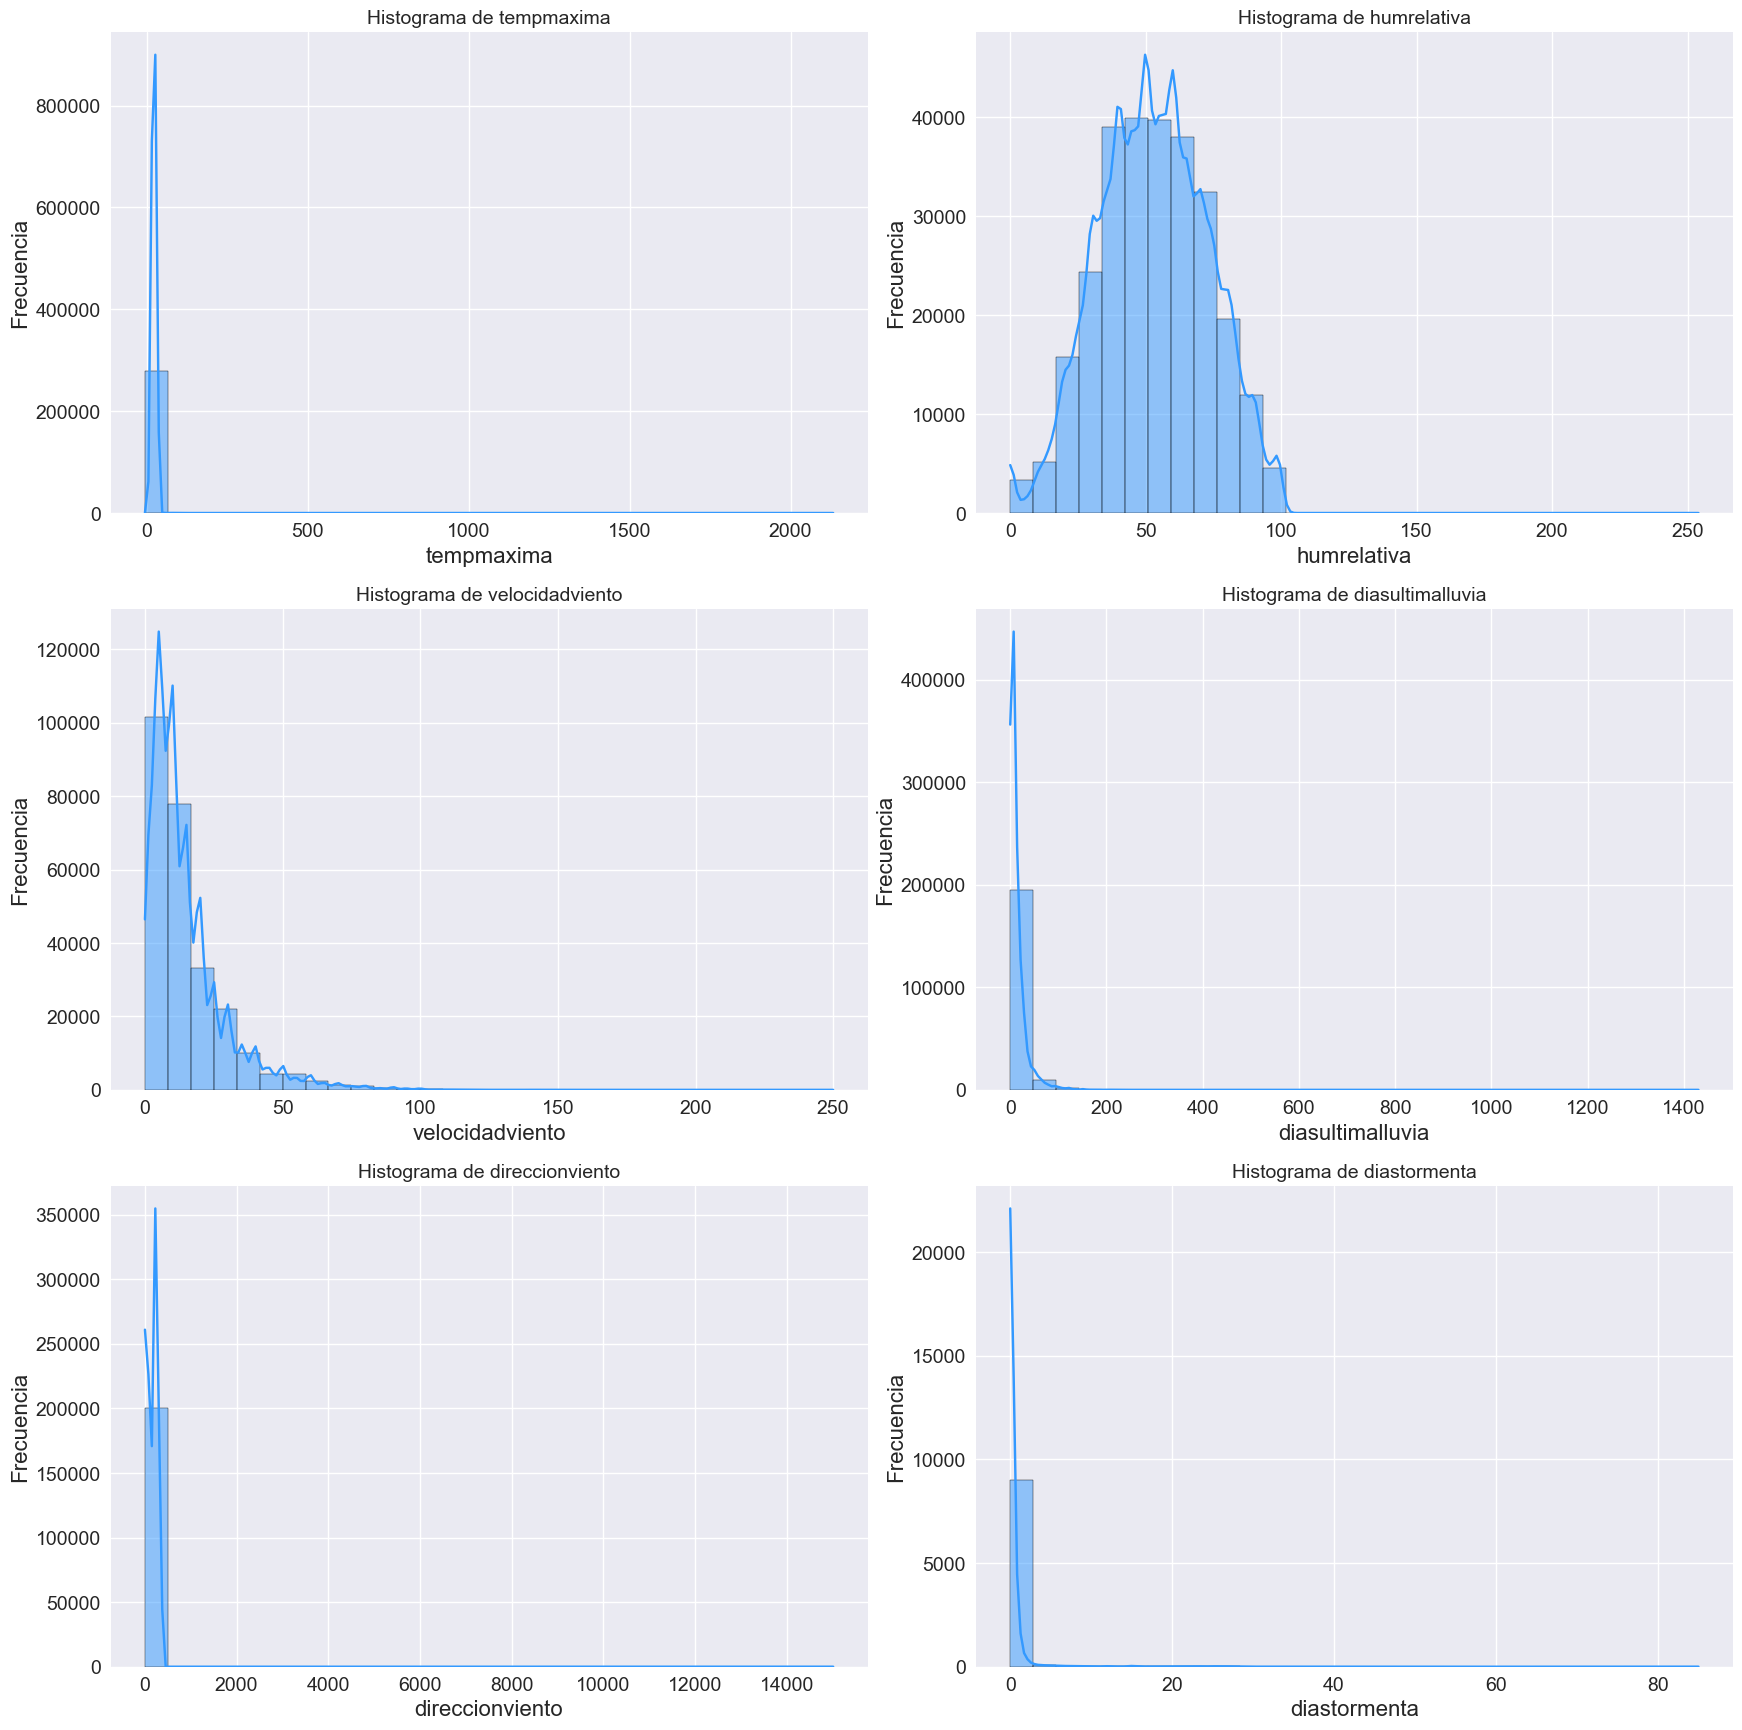

In [51]:
# Creamos una plantilla de 3 filas x 2 columnas
fig, axes = plt.subplots(3, 2, figsize=(18, 18))
fig.tight_layout(pad=5.0)

# Recorrer las columnas y vamos mostrando gráfico a gráfico
for i, col in enumerate(columnas):
    ax = axes[i//2, i%2]  # Posición
    sns.histplot(bdif[col], bins=30, kde=True, color='#3399ff', ax=ax)  # Muestro la curva de densidad
    ax.set_title(f'Histograma de {col}', fontsize=14)  # Título
    ax.set_xlabel(col, fontsize=16)  # Titulo eje x
    ax.set_ylabel('Frecuencia', fontsize=16)  # Titulo eje y
    ax.tick_params(axis='both', which='major', labelsize=14)  # Ajustar letra ejes

# Mostramos el gráfico
plt.show()

# Análisis exploratorio de datos

Analizamos el dataset con las variables meteorologicas extraidas de AEMET.

Introducimos nuevas variables descriptivas la densidad de población, frecuencia de incendios y rango horario.

**Densidad de población**

Se ha introducido la densidad de población como factor humano relevante en la modelización de incendios forestales realizando una estimación lineal y su posterior extrapolación a los cambios poblacionales desde 1974 para cada uno de los municipios afectados.

In [52]:
# Vamos a calcular la densidad de población por superficie de cada municipio
bdif['denpoblacion'] = bdif['poblacion'] / bdif['superficie']

# Mostramos los resultados
print(bdif['denpoblacion'].head())

0    0.041339
1    0.334612
2    0.084859
3    0.139880
4    0.035034
Name: denpoblacion, dtype: float64


**Densidad de incendios por superficie del municipio**

Se hace el cálculo del número acumulado de incendios ocurridos en el mismo municipio en los últimos cinco años dividido por la superficie del municipio en kilómetros cuadrados, para normalizar las diferencias en tamaño superficial de los distintos municipios. La ventana escogida de cinco años para calcular la densidad de incendios en el municipio para tratar de reflejar los cambios que puede haber habido en cuanto a políticas de prevención de incendios forestales, variaciones climáticas o alteraciones en el uso del suelo.


In [53]:
# Hacemos el conteo de los incendios en función del año y el municipio
incendios = bdif.groupby(['id_rel', 'año']).size().reset_index(name='incendios')

# Extraemos la superficie de cada uno de los municipios
superficie = bdif[['id_rel', 'superficie']].drop_duplicates()

# Unimos número de incendios, superficies y años
incendios = pd.merge(incendios, superficie, on='id_rel', how='left')

# Función para calcular la densidad de los incendios en los úlitmos años
def calcular_densidad(municipio):
    # Ordenamos los años
    municipio = municipio.sort_values('año') 
    municipio['denincendios'] = (
        municipio['incendios']
        .rolling(window=5, min_periods=1)  # Ojo! Ventana de 5 años pero para los primeros años hay que poner un minimo
        .sum()
        / municipio['superficie']
    )
    return municipio

# Le pasamos la función al dataframe que hemos creado para guardar los datos para el calculo de la densidad de incendios
denincendios = incendios.groupby('id_rel').apply(calcular_densidad).reset_index(drop=True)

# Hacemos un merge con el dataframe global para tener los datos de densidad de incendios en cada uno de los registros
bdif = pd.merge(bdif, denincendios[['id_rel', 'año', 'denincendios']], on=['id_rel', 'año'],  how='left')

**Rango horario**

Creamos una nueva variable categórica del rango horario de detección del incendio a partir de la variable de fecha y hora de detección del incendio.
- Madrugada: 00 - 06
- Mañana: 06 -12
- Tarde: 12 - 18
- Noche: 18 - 00

In [54]:
# Pasamos la columna fecha a tipo datetime
bdif['horario'] = pd.to_datetime(bdif['deteccion'])

# Creamos una función que nos genere el rango horario al pasarle la hora
def rango_horario(hora):
    """
    Dada una hora la función la clasifica en:
    - Madrugada 0 <= hora < 6
    - Mañana 6 <= hora < 12
    - Tarde 12 <= hora < 18
    - Noche hora >= 18

    Parámetros: hora (tipo datetime)
    Salida: String con la clasificación
    """
    if 0 <= hora < 6:
        return 'Madrugada'
    elif 6 <= hora < 12:
        return 'Mañana'
    elif 12 <= hora < 18:
        return 'Tarde'
    else:
        return 'Noche'

bdif['horario'] = bdif['deteccion'].dt.hour.apply(rango_horario)

# Extraer solo la fecha
bdif['fecha'] = bdif['deteccion'].dt.date

# Eliminar la columna original si no es necesaria
bdif = bdif.drop(columns=['deteccion'])

In [55]:
bdif = bdif[['parte', 'año', 'cod_com', 'cod_prov', 'probignicion','detectadopor', 'fecha', 'combustible', 'fuego',
             'lugar', 'mes', 'dia', 'poblacion', 'superficie', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha','sol', 'hrmedia', 'fwi', 'denpoblacion', 'denincendios', 'horario', 'areaquemada']]

In [56]:
# Estructura del dataframe
bdif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570372 entries, 0 to 570371
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   parte         570372 non-null  int64  
 1   año           570372 non-null  int64  
 2   cod_com       570372 non-null  int64  
 3   cod_prov      570372 non-null  int64  
 4   probignicion  474383 non-null  float64
 5   detectadopor  570000 non-null  object 
 6   fecha         570372 non-null  object 
 7   combustible   570372 non-null  object 
 8   fuego         570372 non-null  object 
 9   lugar         570372 non-null  object 
 10  mes           570372 non-null  object 
 11  dia           570372 non-null  object 
 12  poblacion     570372 non-null  float64
 13  superficie    570372 non-null  float64
 14  altitud       570372 non-null  float64
 15  lon           570372 non-null  float64
 16  lat           570372 non-null  float64
 17  prec          542607 non-null  float64
 18  tmax

In [57]:
# Dimensiones del dataset
bdif.shape

(570372, 29)

In [58]:
bdif.describe().T

,count,mean,std,min,25%,50%,75%,max
parte,570372.0,1.998284e+09,1.015310e+07,1.974020e+09,1.991290e+09,1.999060e+09,2.005390e+09,2.016510e+09
año,570372.0,1.998011e+03,1.014881e+01,1.974000e+03,1.991000e+03,1.999000e+03,2.005000e+03,2.016000e+03
cod_com,570372.0,6.790547e+00,5.268077e+00,1.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01,1.800000e+01
cod_prov,570372.0,2.708861e+01,1.182668e+01,1.000000e+00,1.500000e+01,3.200000e+01,3.600000e+01,5.100000e+01
probignicion,474383.0,1.551928e+01,2.323235e+01,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,1.000000e+02
poblacion,570372.0,1.382367e+04,6.396108e+04,1.000000e+00,1.061038e+03,2.677233e+03,7.999624e+03,3.034878e+06
superficie,570372.0,1.384477e+04,1.673815e+04,1.260000e+00,5.159767e+03,9.364851e+03,1.679586e+04,1.750229e+05
altitud,570372.0,4.442357e+02,3.224960e+02,1.000000e+00,1.580000e+02,4.230000e+02,6.760000e+02,1.695000e+03
lon,570372.0,-5.721403e+00,3.078424e+00,-1.799838e+01,-8.035272e+00,-6.571112e+00,-4.112524e+00,4.289666e+00
lat,570372.0,4.158165e+01,1.992805e+00,2.775610e+01,4.071935e+01,4.223441e+01,4.285315e+01,4.374035e+01


### Datos faltantes

Vamos a ver la cantidad de valores faltantes que hay en cada una de las variables del dataframe

In [59]:
# Nos centramos en buscar los valores faltantes de las condiciones climáticas
faltantes = bdif[['probignicion','detectadopor', 'fecha', 'combustible','fuego', 'lugar', 'mes', 'dia', 'poblacion', 'superficie',
                  'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir','velmedia', 'racha', 'sol','hrmedia','areaquemada', 'fwi',
                 'denpoblacion', 'denincendios', 'horario']].isnull().sum()

In [60]:
faltantes = pd.DataFrame({
    'Variable': faltantes.index,
    'Faltantes': faltantes.values,
    'Porcentaje': (faltantes.values / len(bdif)) * 100
})
faltantes = faltantes[faltantes['Faltantes']>0]
faltantes

,Variable,Faltantes,Porcentaje
0,probignicion,95989,16.829192
1,detectadopor,372,0.065221
13,prec,27765,4.867876
14,tmax,47111,8.259697
15,dir,226420,39.696900
16,velmedia,194712,34.137721
17,racha,213376,37.409971
18,sol,350479,61.447441
19,hrmedia,192065,33.673638
21,fwi,26868,4.710610


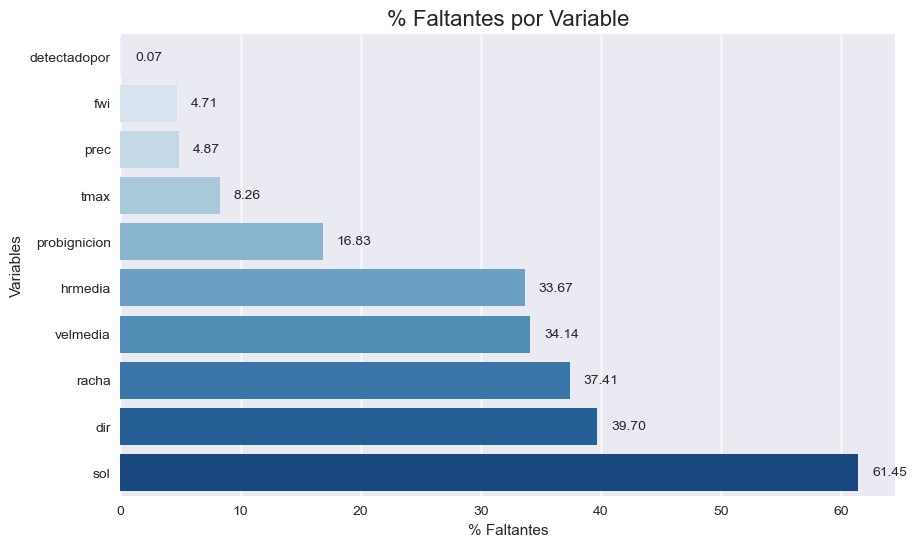

In [61]:
# Ordenamos el dataframe
faltantes = faltantes.sort_values(by='Porcentaje')

# Estilo
plt.style.use("seaborn-v0_8")

# Gráfico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=faltantes, x='Porcentaje', y='Variable', hue='Variable', palette='Blues')

# Porcentajes sobre las barras
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.2f'),
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center',
                xytext=(10, 0), textcoords='offset points')

# Mostramos el gráfico
plt.title('% Faltantes por Variable', fontsize=16)
plt.xlabel('% Faltantes')
plt.ylabel('Variables')
plt.show()

Ahora vamos a filtrar los registros con valores nulos en cualquier columna del dataset, contaremos estos registros y veremos su distribución en funcion de la categoria de area quemada. Para ello vamos a tener en cuenta la division que se hace en:
- Conatos <= 1 ha
- Incendios > 1 ha y < 500 ha
- Gran Incendio Forestal (gif) >= 500 ha

Crearemos una nueva columna en el dataset que recoja esta categorización

In [62]:
# Crear la función
def clasificar_incendio(area):
    """
    Dado un dato de area quemada de incendio la función lo clasifica en:
    - Conatos <= 1 ha
    - Incendios > 1 ha y < 500 ha
    - Gran Incendio Forestal (gif) >= 500 ha

    Párametros: Float dato numérico de entrada
    Salida: String con la clasificación
    """
    if area <= 1:
        return 'conato'
    elif area < 500:
        return 'incendio'
    else:
        return 'gif'

# Aplicamos la función al dataset
bdif['claseincendio'] = bdif['areaquemada'].apply(clasificar_incendio)
# Comprobamos los cambios
bdif['claseincendio'].head()

0    incendio
1      conato
2      conato
3    incendio
4      conato
Name: claseincendio, dtype: object

Ahora que hemos incluido la categorización oficial de incendios, vamos a analizar los faltantes por categoria:

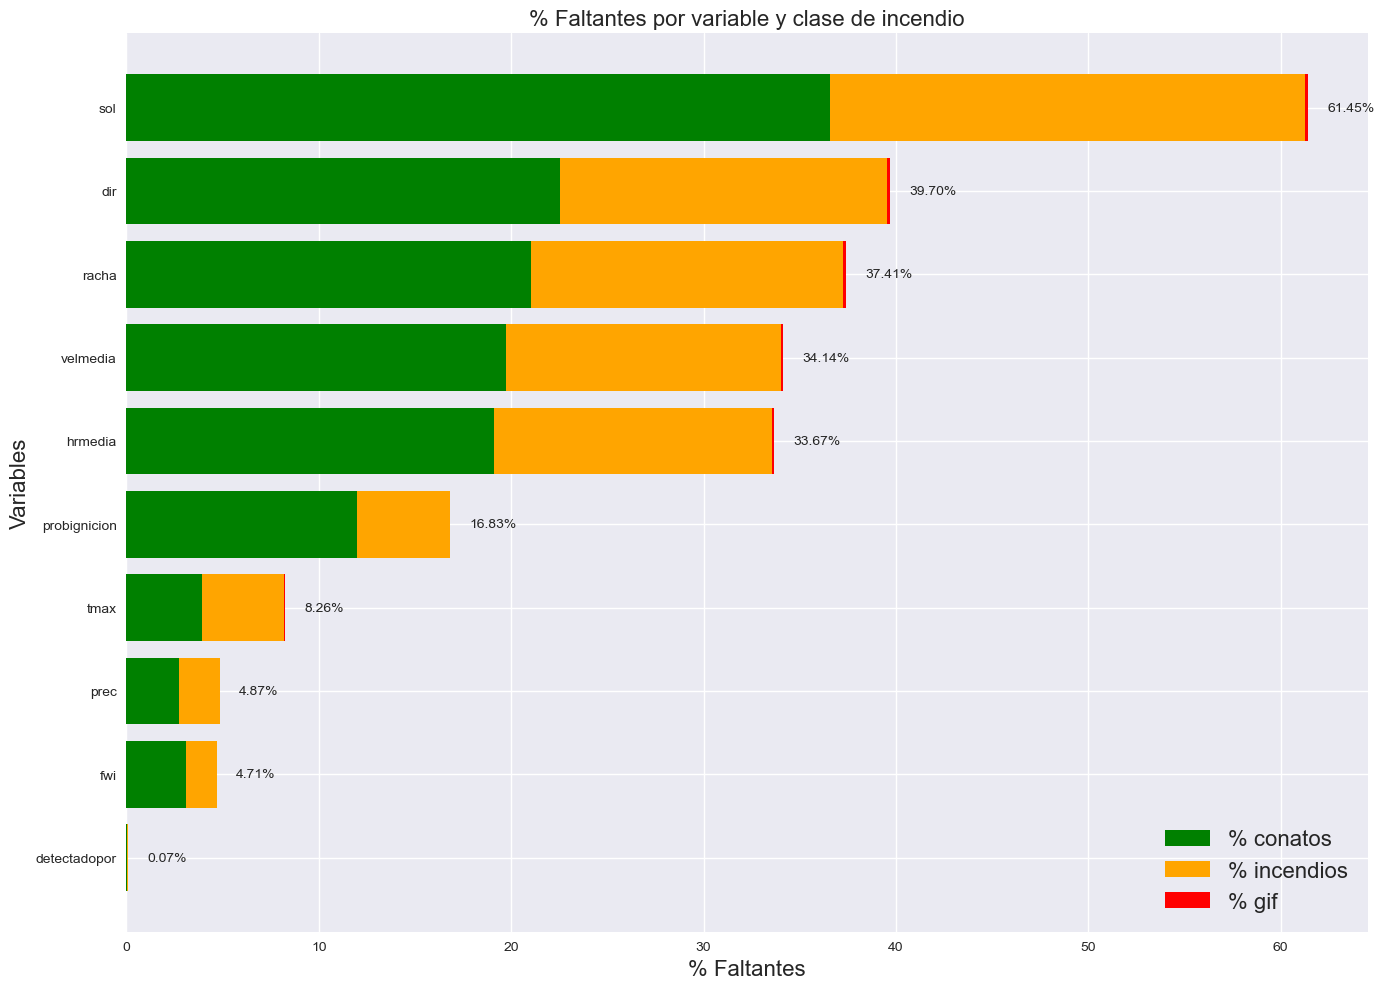

In [63]:
# Filtramos por clases
conatos = bdif[bdif['claseincendio'] == 'conato']
incendios = bdif[bdif['claseincendio'] == 'incendio']
gif = bdif[bdif['claseincendio'] == 'gif']

# Realizamos el cálculo de valores faltantes en cada una de las clases y en total en el dataset
faltantes_conato = conatos.isnull().sum()
faltantes_conato = pd.DataFrame({
    'Variable': faltantes_conato.index,
    'Faltantes conato': faltantes_conato.values
})

faltantes_incendio = incendios.isnull().sum()
faltantes_incendio = pd.DataFrame({
    'Variable': faltantes_incendio.index,
    'Faltantes incendio': faltantes_incendio.values
})

faltantes_gif = gif.isnull().sum()
faltantes_gif = pd.DataFrame({
    'Variable': faltantes_gif.index,
    'Faltantes gif': faltantes_gif.values
})

faltantes_totales = bdif.isnull().sum()
faltantes_totales = pd.DataFrame({
    'Variable': faltantes_totales.index,
    'Total faltantes': faltantes_totales.values
})

# Unir todos los dataframes
faltantes_comparacion = pd.merge(faltantes_totales, faltantes_conato, on='Variable', how='left')
faltantes_comparacion = pd.merge(faltantes_comparacion, faltantes_incendio, on='Variable', how='left')
faltantes_comparacion = pd.merge(faltantes_comparacion, faltantes_gif, on='Variable', how='left')

# Agregamos los porcentajes
faltantes_comparacion['% conato'] = (faltantes_comparacion['Faltantes conato'] / len(bdif)) * 100
faltantes_comparacion['% incendio'] = (faltantes_comparacion['Faltantes incendio'] / len(bdif)) * 100
faltantes_comparacion['% gif'] = (faltantes_comparacion['Faltantes gif'] / len(bdif)) * 100
faltantes_comparacion['% total'] = (faltantes_comparacion['Total faltantes'] / len(bdif)) * 100

# Filtrar variables con valores faltantes en cualquiera de las clases
faltantes_comparacion = faltantes_comparacion[
    (faltantes_comparacion['Faltantes conato'] > 1) |
    (faltantes_comparacion['Faltantes incendio'] > 1) |
    (faltantes_comparacion['Faltantes gif'] > 1)
]

# Ordenar por porcentaje
faltantes_comparacion = faltantes_comparacion.sort_values(by='% total')

# Lienzo
plt.figure(figsize=(14, 10))

# Estilo
plt.style.use("seaborn-v0_8")

# Gráfico de barras apiladas
plt.barh(
    faltantes_comparacion['Variable'],
    faltantes_comparacion['% conato'],
    color='green',
    label='% conatos'
)

plt.barh(
    faltantes_comparacion['Variable'],
    faltantes_comparacion['% incendio'],
    left=faltantes_comparacion['% conato'],
    color='orange',
    label='% incendios'
)

plt.barh(
    faltantes_comparacion['Variable'],
    faltantes_comparacion['% gif'],
    left=faltantes_comparacion['% conato'] + faltantes_comparacion['% incendio'],
    color='red',
    label='% gif'
)

# Etiquetas de las barras
for i, (v_conato, v_incendio, v_gif) in enumerate(zip(faltantes_comparacion['% conato'], faltantes_comparacion['% incendio'], faltantes_comparacion['% gif'])):
    total = v_conato + v_incendio + v_gif
    plt.text(total + 1, i, f'{total:.2f}%', va='center', ha='left')

# Títulos y etiquetas
plt.title('% Faltantes por variable y clase de incendio', fontsize=16)
plt.xlabel('% Faltantes', fontsize=16)
plt.ylabel('Variables', fontsize=16)
plt.legend(loc='lower right', fontsize=16)

# Ajustar el gráfico
plt.tight_layout()
plt.show()

En el gráfico vemos que los datos faltantes se distribuyen de la misma forma por variable y clase de incendio.

### Imputación de datos faltantes
Imputar media y moda

In [64]:
bdif_save = bdif.copy()
bdif_save.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.9,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.1,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.1,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,NaN,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,NaN,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


In [65]:
# Variables categoricas que ademas suponen un porcentaje ínfimo le imputamos la moda
bdif['detectadopor'] = bdif['detectadopor'].fillna(bdif['detectadopor'].mode()[0])
bdif['lugar'] = bdif['lugar'].fillna(bdif['lugar'].mode()[0])
bdif['fuego'] = bdif['fuego'].fillna(bdif['fuego'].mode()[0])

In [66]:
# Variable numérica de probabilidad de ignición teniendo en cuenta la media de la provincia
bdif['probignicion'] = bdif.groupby(['cod_prov'])['probignicion'].transform(lambda x: x.fillna(x.mean()))
print(bdif['probignicion'].isnull().sum())

0


In [67]:
# Vamos aplicando la media de mayor granularidad a mayor teniendo en cuenta terreno y fecha
bdif['fwi'] = bdif.groupby(['fecha', 'cod_prov'])['fwi'].transform(lambda x: x.fillna(x.mean()))
bdif['fwi'] = bdif.groupby(['fecha', 'cod_com'])['fwi'].transform(lambda x: x.fillna(x.mean()))
bdif['fwi'] = bdif.groupby(['año', 'mes', 'cod_prov'])['fwi'].transform(lambda x: x.fillna(x.mean()))
bdif['fwi'] = bdif.groupby(['año', 'mes', 'cod_com'])['fwi'].transform(lambda x: x.fillna(x.mean()))
bdif['fwi'] = bdif.groupby(['mes', 'cod_prov'])['fwi'].transform(lambda x: x.fillna(x.mean()))
# De la Ceuto no teniamos datos asi que asignamos valor de FWI = 1 
bdif.loc[bdif['cod_com'] == 18, 'fwi'] = 1
print(bdif['fwi'].isnull().sum())

0


In [68]:
# Variables numéricas climatológicas vamos a imputar valore en función de la media de año, mes y provincia
bdif['prec'] = bdif.groupby(['año', 'mes', 'cod_prov'])['prec'].transform(lambda x: x.fillna(x.mean()))
bdif['tmax'] = bdif.groupby(['año', 'mes', 'cod_prov'])['tmax'].transform(lambda x: x.fillna(x.mean()))
bdif['dir'] = bdif.groupby(['año', 'mes', 'cod_prov'])['dir'].transform(lambda x: x.fillna(x.mean()))
bdif['velmedia'] = bdif.groupby(['año', 'mes', 'cod_prov'])['velmedia'].transform(lambda x: x.fillna(x.mean()))
bdif['racha'] = bdif.groupby(['año', 'mes', 'cod_prov'])['racha'].transform(lambda x: x.fillna(x.mean()))
bdif['sol'] = bdif.groupby(['año', 'mes', 'cod_prov'])['sol'].transform(lambda x: x.fillna(x.mean()))
bdif['hrmedia'] = bdif.groupby(['año', 'mes', 'cod_prov'])['hrmedia'].transform(lambda x: x.fillna(x.mean()))

In [69]:
# Variables numéricas climatológicas vamos a imputar valore en función de la media de año, mes y comunidad
bdif['prec'] = bdif.groupby(['año', 'mes', 'cod_com'])['prec'].transform(lambda x: x.fillna(x.mean()))
bdif['tmax'] = bdif.groupby(['año', 'mes', 'cod_com'])['tmax'].transform(lambda x: x.fillna(x.mean()))
bdif['dir'] = bdif.groupby(['año', 'mes', 'cod_com'])['dir'].transform(lambda x: x.fillna(x.mean()))
bdif['velmedia'] = bdif.groupby(['año', 'mes', 'cod_com'])['velmedia'].transform(lambda x: x.fillna(x.mean()))
bdif['racha'] = bdif.groupby(['año', 'mes', 'cod_com'])['racha'].transform(lambda x: x.fillna(x.mean()))
bdif['sol'] = bdif.groupby(['año', 'mes', 'cod_com'])['sol'].transform(lambda x: x.fillna(x.mean()))
bdif['hrmedia'] = bdif.groupby(['año', 'mes', 'cod_com'])['hrmedia'].transform(lambda x: x.fillna(x.mean()))

In [70]:
# Variables numéricas climatológicas vamos a imputar valore en función de la media de mes y provincia
bdif['prec'] = bdif.groupby(['mes', 'cod_prov'])['prec'].transform(lambda x: x.fillna(x.mean()))
bdif['tmax'] = bdif.groupby(['mes', 'cod_prov'])['tmax'].transform(lambda x: x.fillna(x.mean()))
bdif['dir'] = bdif.groupby(['mes', 'cod_prov'])['dir'].transform(lambda x: x.fillna(x.mean()))
bdif['velmedia'] = bdif.groupby(['mes', 'cod_prov'])['velmedia'].transform(lambda x: x.fillna(x.mean()))
bdif['racha'] = bdif.groupby(['mes', 'cod_prov'])['racha'].transform(lambda x: x.fillna(x.mean()))
bdif['sol'] = bdif.groupby(['mes', 'cod_prov'])['sol'].transform(lambda x: x.fillna(x.mean()))
bdif['hrmedia'] = bdif.groupby(['mes', 'cod_prov'])['hrmedia'].transform(lambda x: x.fillna(x.mean()))

In [71]:
print(bdif['prec'].isnull().sum())
print(bdif['tmax'].isnull().sum())
print(bdif['dir'].isnull().sum())
print(bdif['velmedia'].isnull().sum())
print(bdif['racha'].isnull().sum())
print(bdif['sol'].isnull().sum())
print(bdif['hrmedia'].isnull().sum())

0
0
0
0
0
0
0


### Revisión de duplicados

Comprobamos si hay elementos duplicados

In [72]:
# Comprobamos si hay valores duplicados
bdif.duplicated().sum()

0

In [73]:
bdif.shape

(570372, 30)

**Exportación de la base de datos**

In [33]:
bdif.to_excel("bdif_modelo.xlsx", index=False)

## Análisis univariante

### Variables numéricas

In [33]:
# Si necesitamos cargar el dataset con todas las imputaciones realizadas en este punto
#bdif = pd.read_excel("bdif_modelo.xlsx")

In [35]:
# Seleccionamos las variables numéricas
numericas = ['probignicion', 'poblacion', 'superficie', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir',
            'velmedia', 'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi', 'areaquemada']

**Descriptivos básicos**

In [36]:
bdif[numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
probignicion,570372.0,14.771302,21.657798,0.000000,0.000000,0.000000,30.000000,1.000000e+02
poblacion,570372.0,13823.670034,63961.083329,1.000000,1061.037720,2677.232632,7999.623597,3.034878e+06
superficie,570372.0,13844.766023,16738.152259,1.260000,5159.767500,9364.851100,16795.857000,1.750229e+05
altitud,570372.0,444.235716,322.496031,1.000000,158.000000,423.000000,676.000000,1.695000e+03
lon,570372.0,-5.721403,3.078424,-17.998381,-8.035272,-6.571112,-4.112524,4.289666e+00
lat,570372.0,41.581651,1.992805,27.756103,40.719346,42.234413,42.853151,4.374035e+01
prec,570372.0,0.632092,3.208286,0.000000,0.000000,0.000000,0.000000,1.600000e+02
tmax,570372.0,24.560029,7.215267,-8.500000,19.700000,25.000000,30.000000,4.660000e+01
dir,570372.0,19.092042,8.848017,0.000000,13.000000,19.796117,26.000000,3.600000e+01
velmedia,570372.0,2.759745,1.708335,0.000000,1.700000,2.500000,3.340000,3.140000e+01


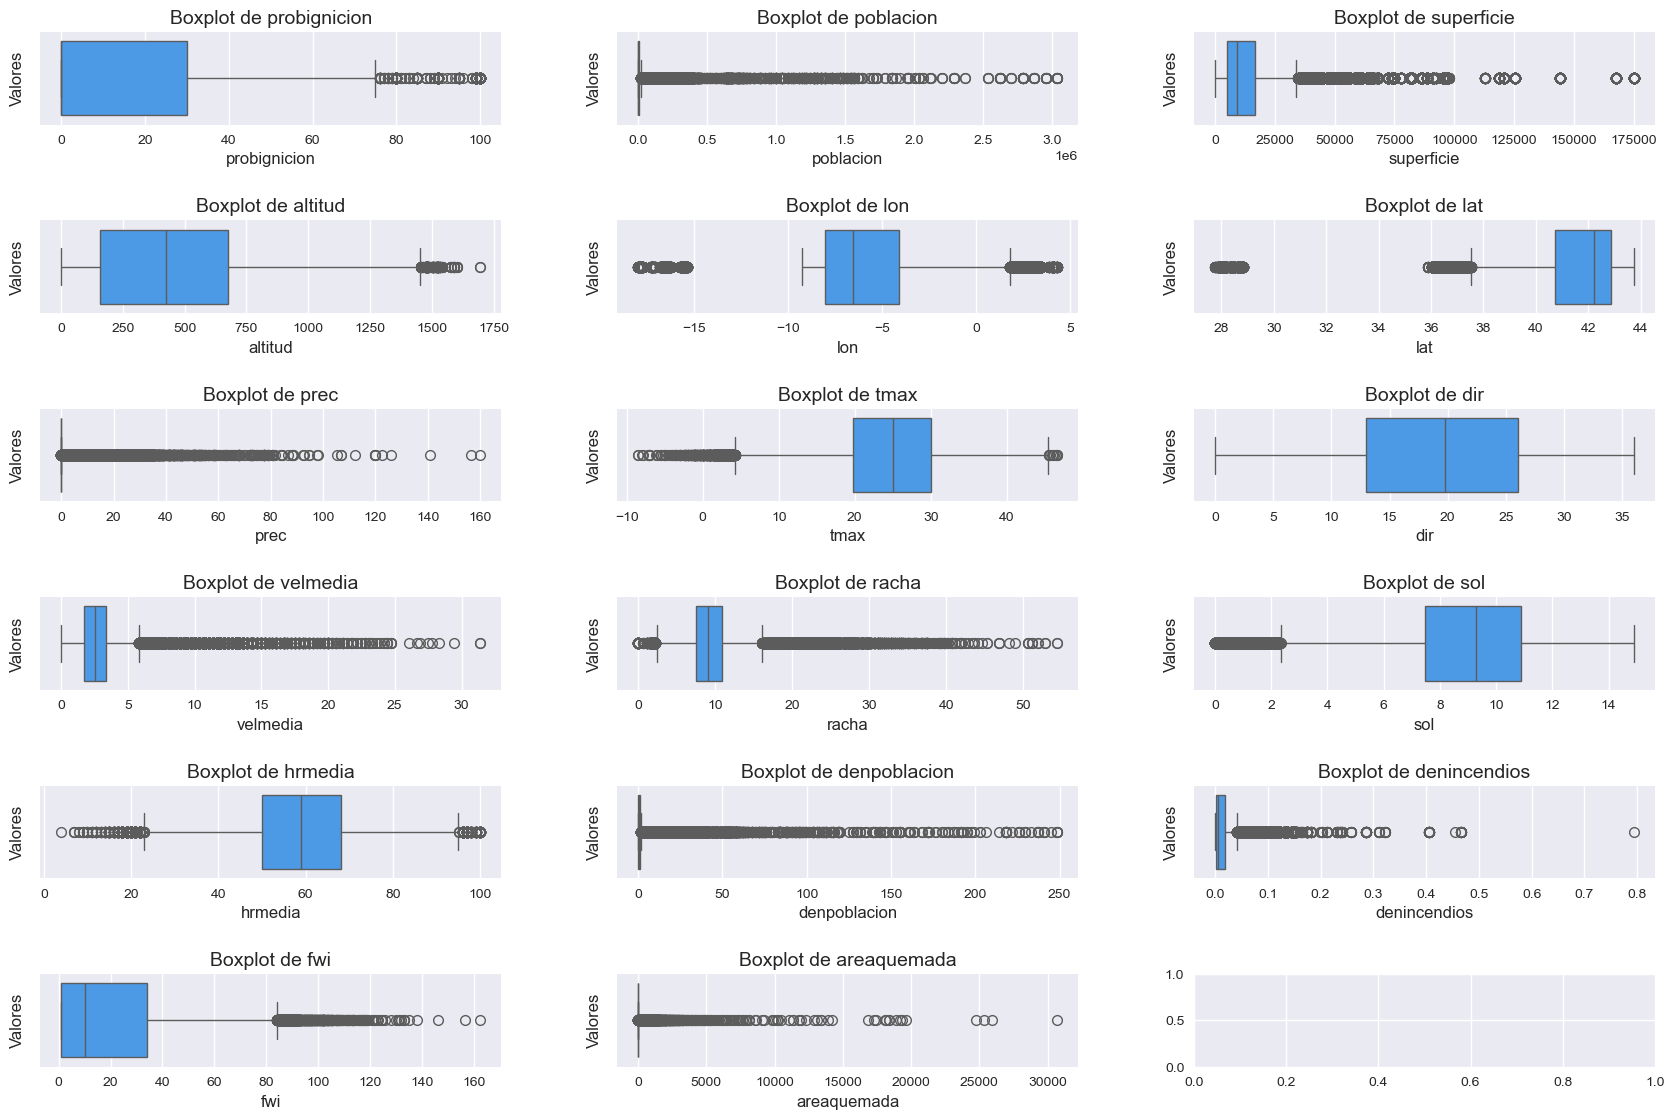

In [37]:
# Creamos la plantilla para albergar los graficos
fig, axes = plt.subplots(6, 3, figsize=(18, 12))
fig.tight_layout(pad=5.0)

# Estilo
plt.style.use("seaborn-v0_8")

# Vamos recorriendo variable variable haciendo el grafico
for i, col in enumerate(numericas):
    ax = axes[i//3, i%3]  #Posicion
    sns.boxplot(x=bdif[col], color='#3399ff', ax=ax)  # Boxplot
    ax.set_title(f'Boxplot de {col}', fontsize=14)  # Título
    ax.set_xlabel(col, fontsize=12)  # Eje X
    ax.set_ylabel('Valores', fontsize=12)  # Eje Y
    ax.tick_params(axis='both', which='major', labelsize=10)  # Tamaño letra

# Ajustar la visualización
plt.show()

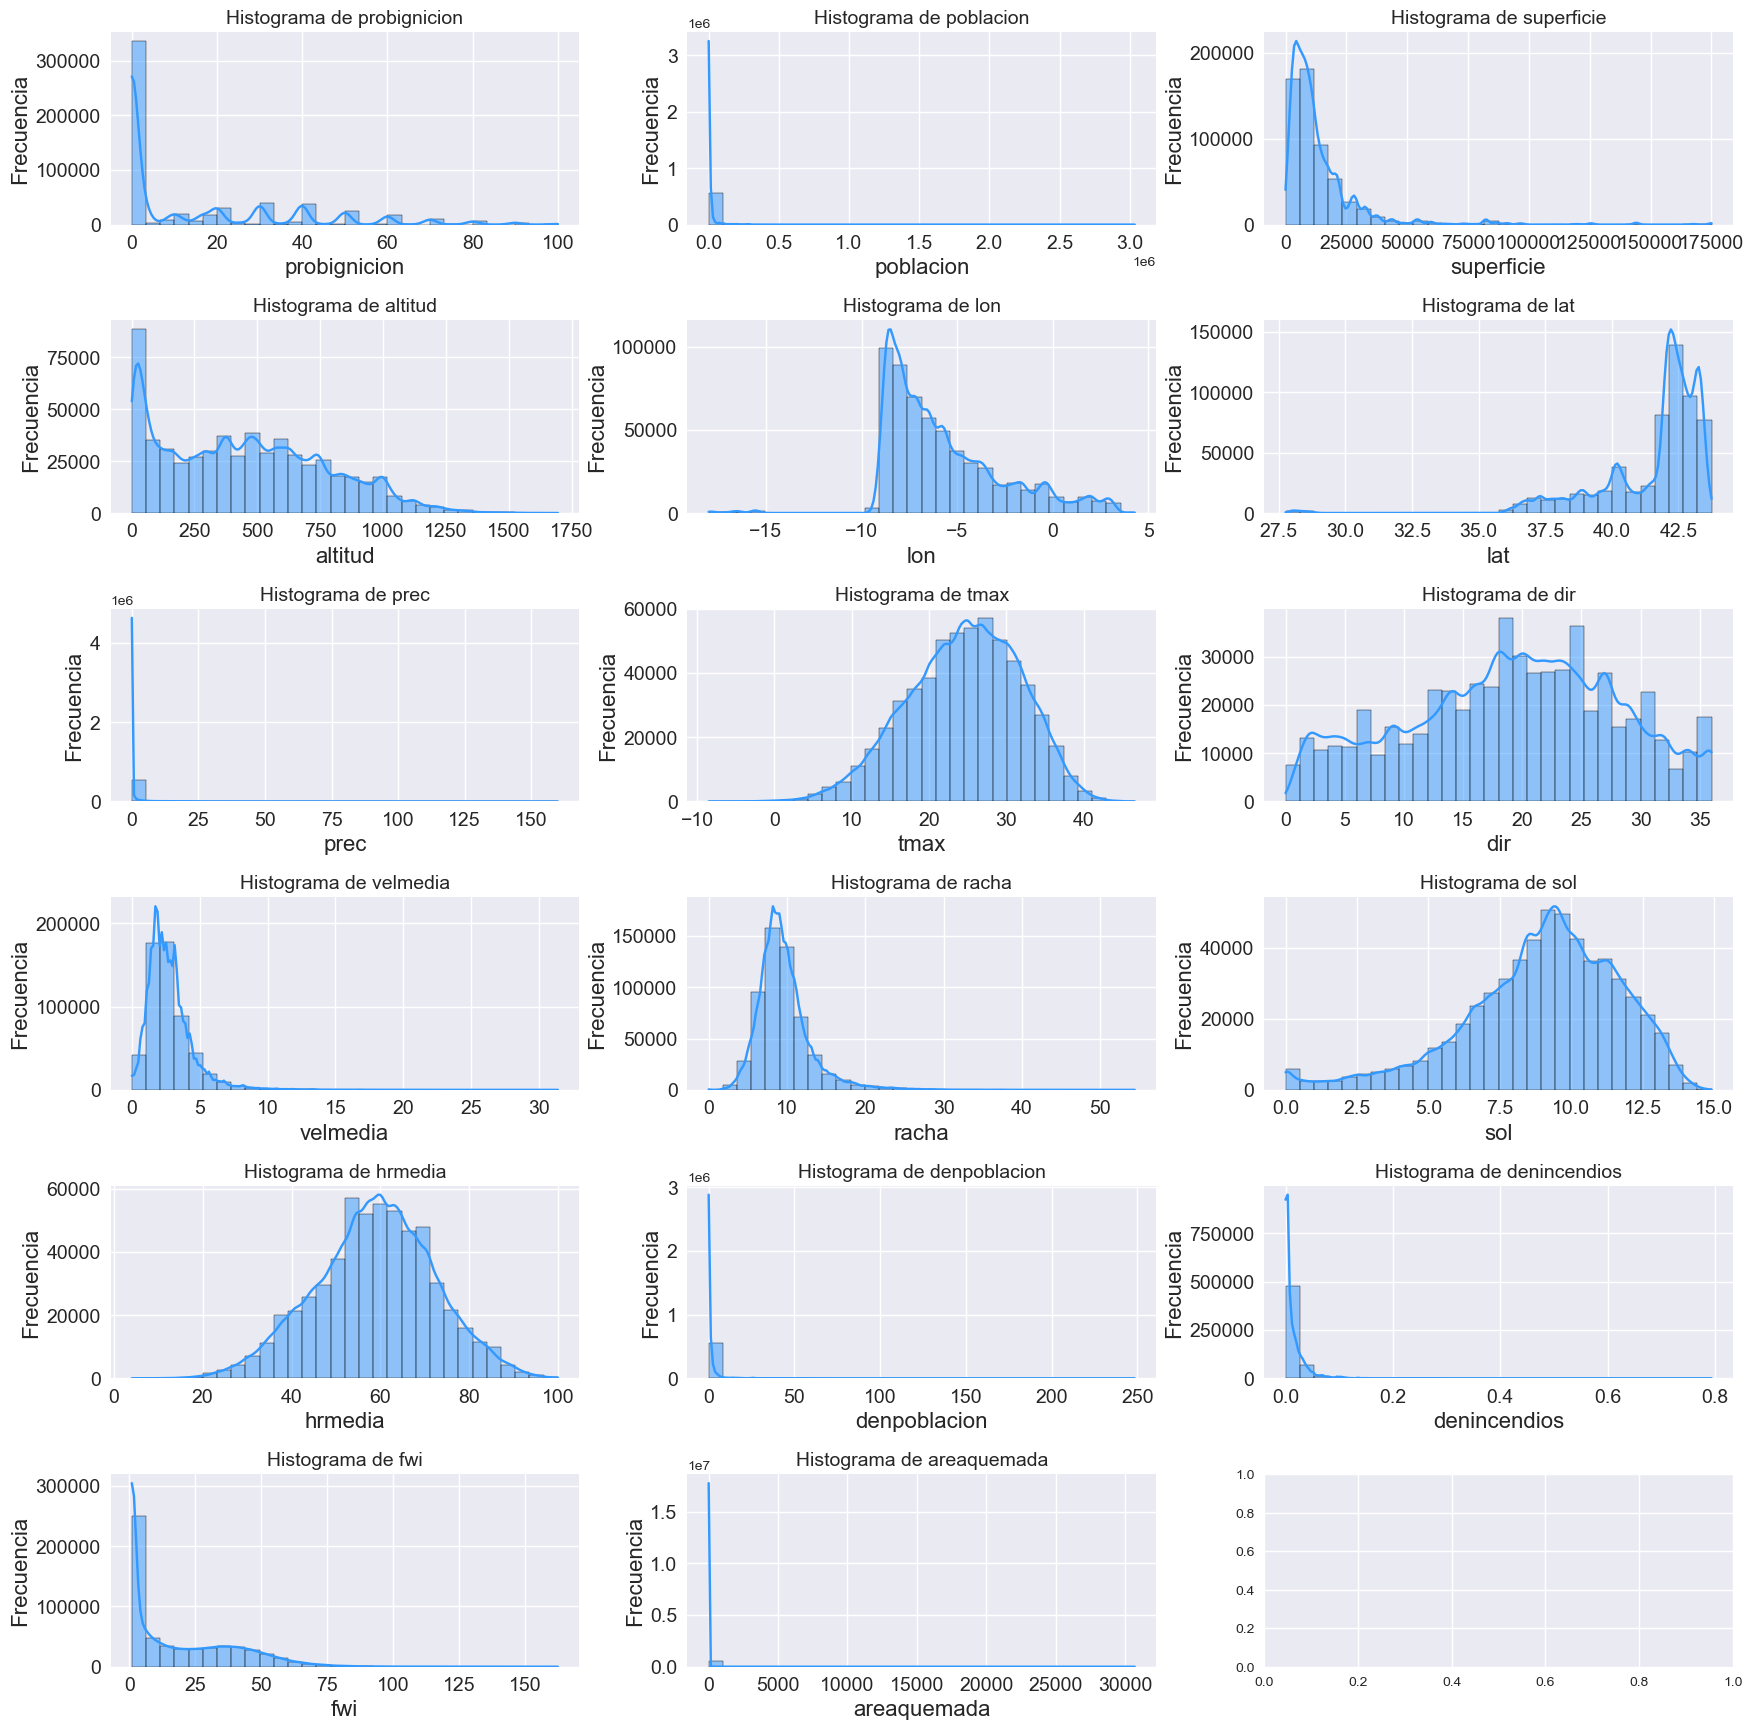

In [71]:
# Creamos una plantilla de 6 filas x 3 columnas
fig, axes = plt.subplots(6, 3, figsize=(18, 18))
fig.tight_layout(pad=5.0)

# Estilo
plt.style.use("seaborn-v0_8")

# Recorrer las columnas y vamos mostrando gráfico a gráfico
for i, col in enumerate(numericas):
    ax = axes[i//3, i%3]  # Posición
    sns.histplot(bdif[col], bins=30, kde=True, color='#3399ff', ax=ax)  # Muestro la curva de densidad
    ax.set_title(f'Histograma de {col}', fontsize=14)  # Título
    ax.set_xlabel(col, fontsize=16)  # Titulo eje x
    ax.set_ylabel('Frecuencia', fontsize=16)  # Titulo eje y
    ax.tick_params(axis='both', which='major', labelsize=14)  # Ajustar letra ejes

# Mostramos el gráfico
plt.show()

### Variables categóricas

In [72]:
# Seleccionamos las variables categoricas
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario', 'claseincendio']

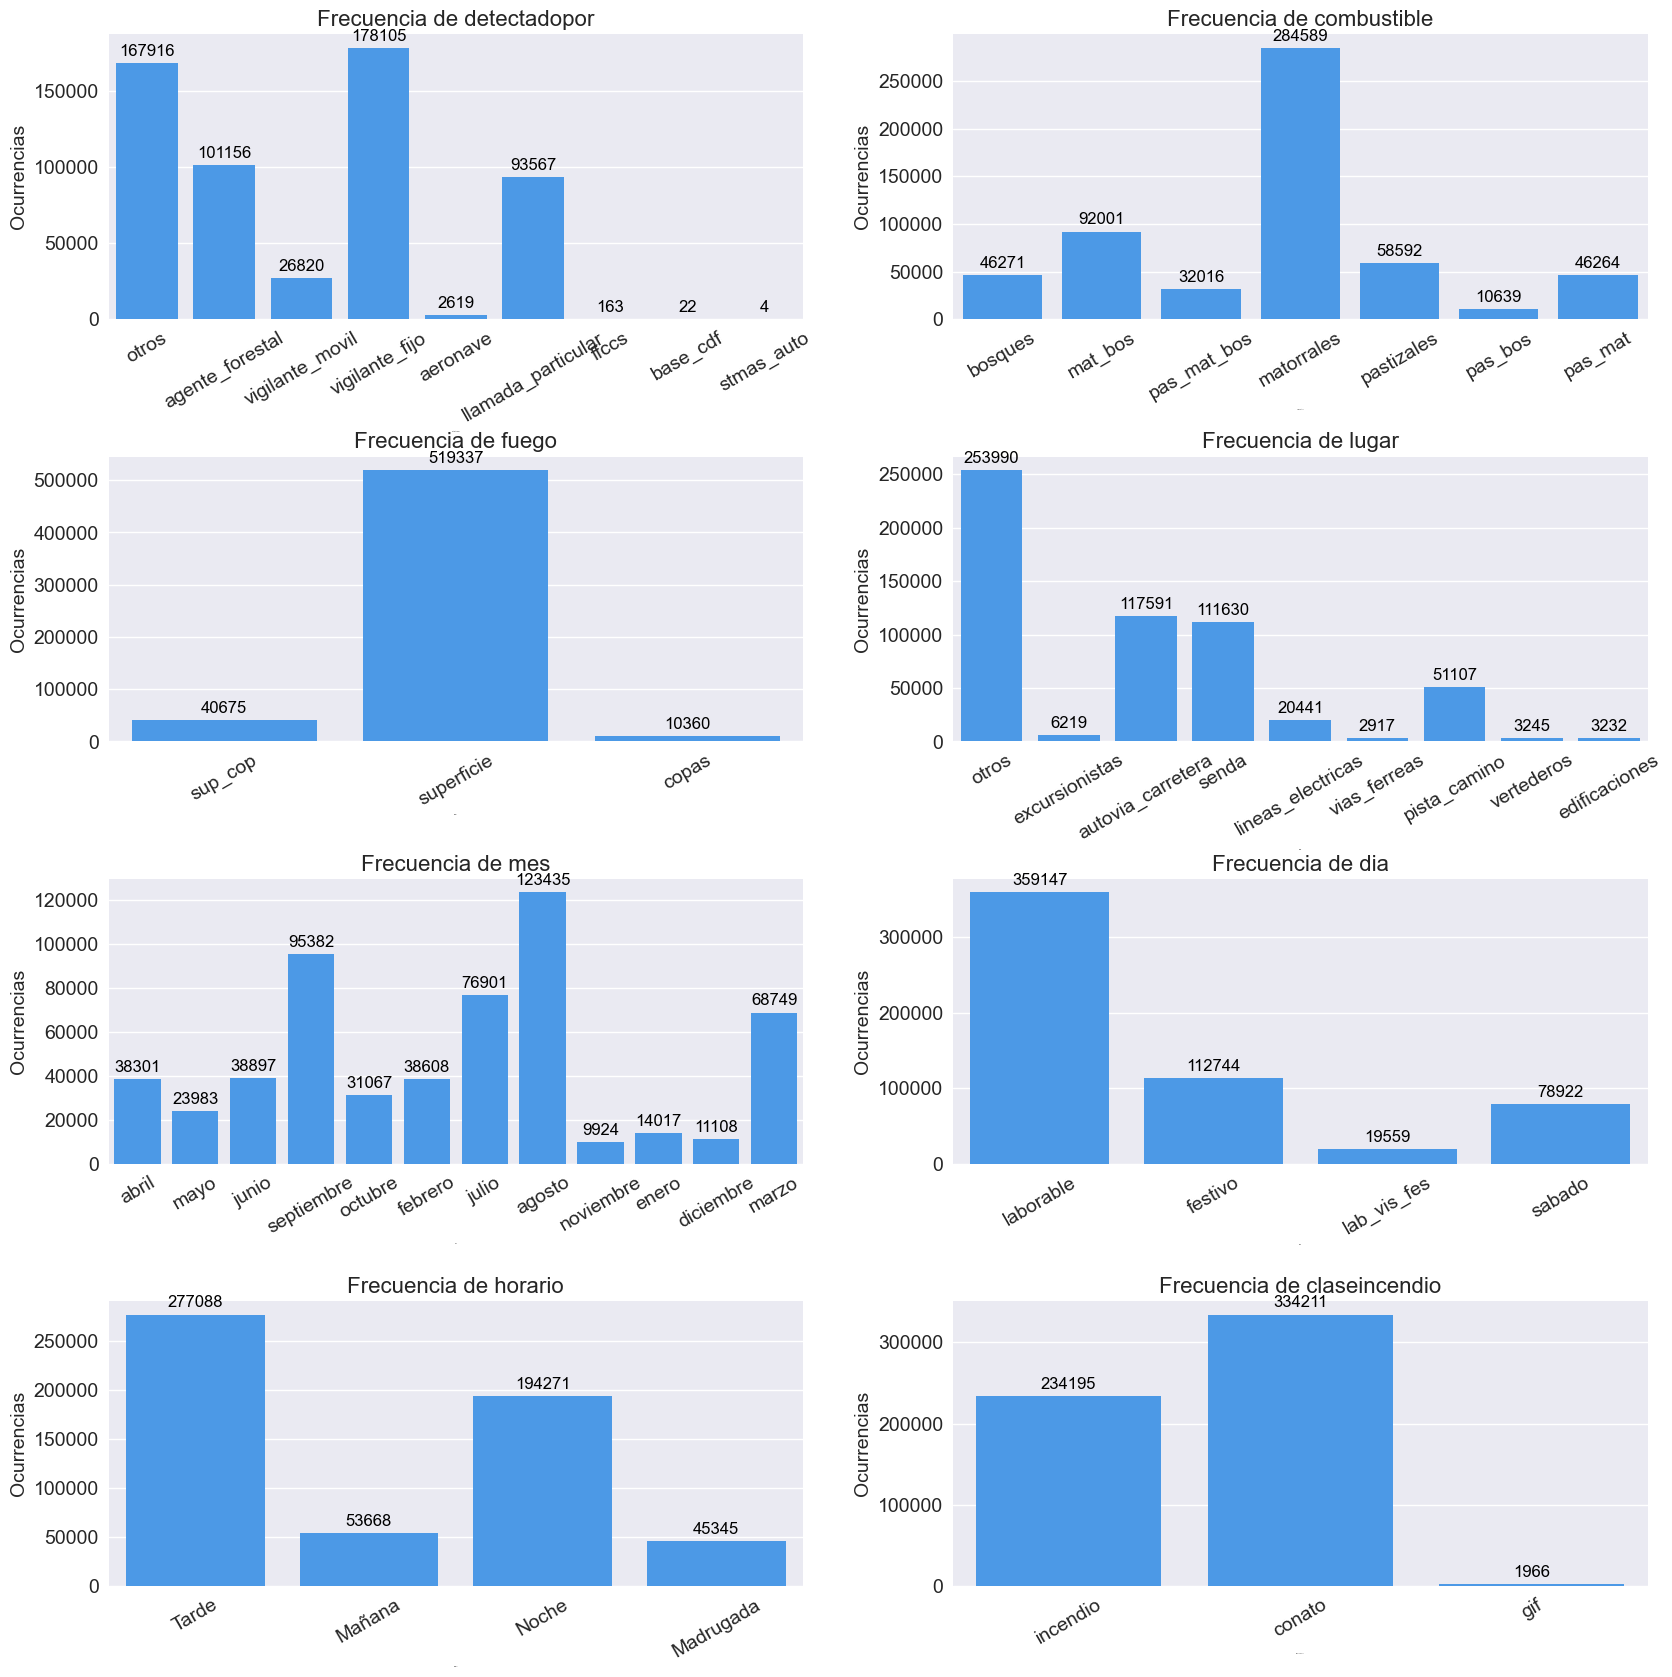

In [73]:
# Creamos una plantilla de 4 filas x 2 columnas
fig, axes = plt.subplots(4, 2, figsize=(18, 18))
fig.tight_layout(pad=8.0)

# Estilo
plt.style.use("seaborn-v0_8")

# Recorrer las columnas y vamos mostrando gráfico a gráfico
for i, col in enumerate(categoricas):
    ax = axes[i//2, i%2]  # Posición
    plot = sns.countplot(data=bdif, x=col, color='#3399ff', ax=ax)  # Gráfico de barras
    
    # Añadir recuento encima de las barras
    for container in plot.containers:
        plot.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3, color='black')

    ax.set_title(f'Frecuencia de {col}', fontsize=16)  # Título
    ax.set_xlabel(col, fontsize=0)  # Titulo eje x
    ax.set_ylabel('Ocurrencias', fontsize=14)  # Titulo eje y
    ax.tick_params(axis='x', which='major', rotation=30, labelsize=14)  # Ajustar letra ejes
    ax.tick_params(axis='y', which='major', labelsize=14)  # Ajustar letra ejes

# Mostramos el gráfico
plt.show()

### Análisis de las variables categóricas

Al examinar los diagramas de frecuencia de las variables categóricas, se identifican categorías con pocas ocurrencias y que son susceptibles de ser eliminadas o agrupadas para simplificar el análisis y el modelo. Se observan los siguientes casos:

- **Forma de detección del incendio.** Categorías como *aeronave*, *ffccs*, *base_cdf* y *sistemas automáticos* tienen pocas ocurrencias, lo que implica que podrían ser poco significativas para el modelo.

- **Lugar representativo de inicio del incendio.** Algunas categorías como las inmediaciones de zonas por donde pasan excursionistas, las vías férreas, los vertederos y las edificaciones tienen una baja representación, por lo que se podrían reagrupar.

- **El tipo de día.** Los días laborables que son víspera de festivos presentan un número de ocurrencias bastante menor al resto de días, lo que podría indicar una baja influencia en el comportamiento de los incendios.

- **El tipo de fuego.** La categoría *fuegos de superficie* domina esta variable, lo que sugiere que su influencia en el modelado de los incendios podría ser limitada.

- **El mes de ocurrencia de los incendios.** Como era de esperar, la temporada estival destaca por su mayor concentración de incendios. No obstante, resalta el mes de marzo por presentar una frecuencia significativa de incendios.

- **El horario de detección de los incendios** se produce en la franja de *tarde* y *noche* mayoritariamente.

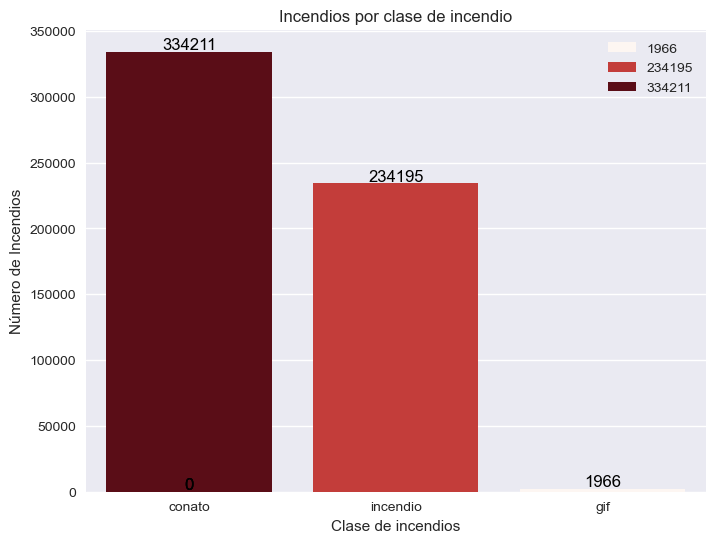

In [74]:
# Contamos el número de incendios en cada clase
conteo_clase_incendio = bdif['claseincendio'].value_counts()

# Estilo
plt.style.use("seaborn-v0_8")

# Utilizamos el diagrama de barras
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=conteo_clase_incendio.index, y=conteo_clase_incendio.values, hue=conteo_clase_incendio.values, palette='Reds')

# Agregar los valores numéricos sobre las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Títulos
plt.title('Incendios por clase de incendio')
plt.xlabel('Clase de incendios')
plt.ylabel('Número de Incendios')

# Mostramos el gráfico
plt.show()

En este diagrama de frecuencias se representan los incendios forestales ocurridos en España entre 1974 y 2016. La mayoría de los casos corresponden a conatos, es decir, incendios cuya superficie quemada es menor a 1 hectárea. Sin embargo, existe una gran variabilidad en los incendios restantes: una parte significativa abarca superficies quemadas desde 1 hasta 500 hectáreas, mientras que los grandes incendios forestales, que constituyen la clase minoritaria con solo 1.966 registros, presentan áreas quemadas que oscilan entre 500 y 31.000 hectáreas.

Esta distribución plantea un problema para modelar el comportamiento de los incendios. Los grandes incendios forestales, por su baja frecuencia y gran variabilidad, podrían ser interpretados por el modelo como datos atípicos. No obstante, es importante desarrollar un modelo que sea capaz de caracterizar esta clase de incendios, ya que son los más destructivos y virulentos.

## Análisis bivariante

### Variables numéricas

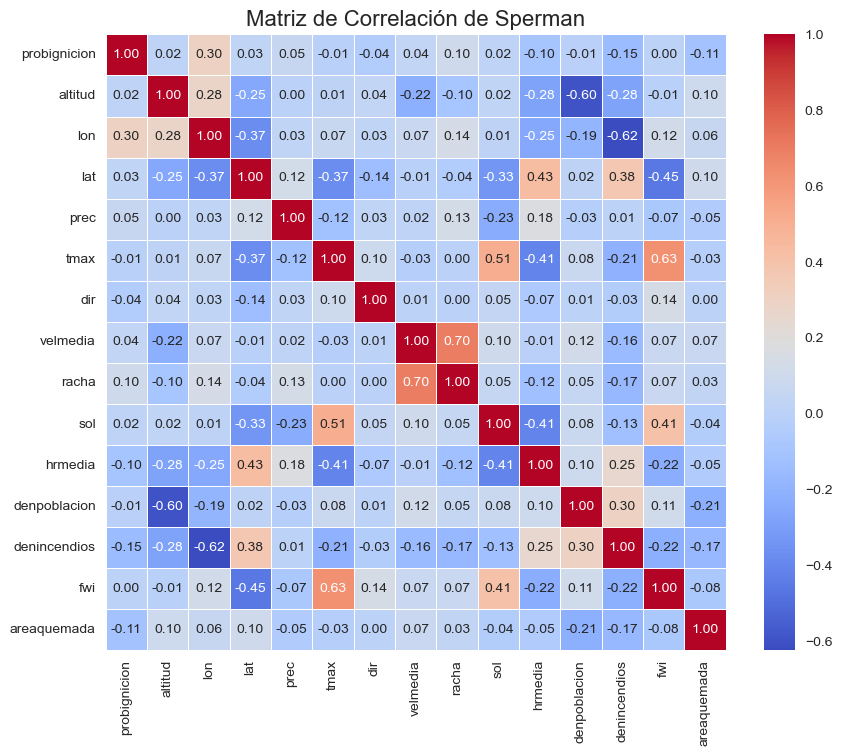

In [75]:
# Seleccionamos las variables numéricas
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia', 'racha', 'sol', 'hrmedia',
             'denpoblacion', 'denincendios', 'fwi', 'areaquemada']

# Calculamos la matriz de correlación
correlation_matrix_spearman = bdif[numericas].corr(method='spearman')

# Configuramos el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Creamos un mapa de calor con Seaborn
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Títulos y etiquetas
plt.title('Matriz de Correlación de Sperman', fontsize=16)
#plt.xticks(rotation=45)
#plt.yticks(rotation=45)

# Mostramos el gráfico
plt.show()

Mostramos todas las relaciones posibles entre las variables numéricas del dataset mediante un pairplot.

## Variables categóricas

In [76]:
# Seleccionar variables categoricas
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario', 'claseincendio']

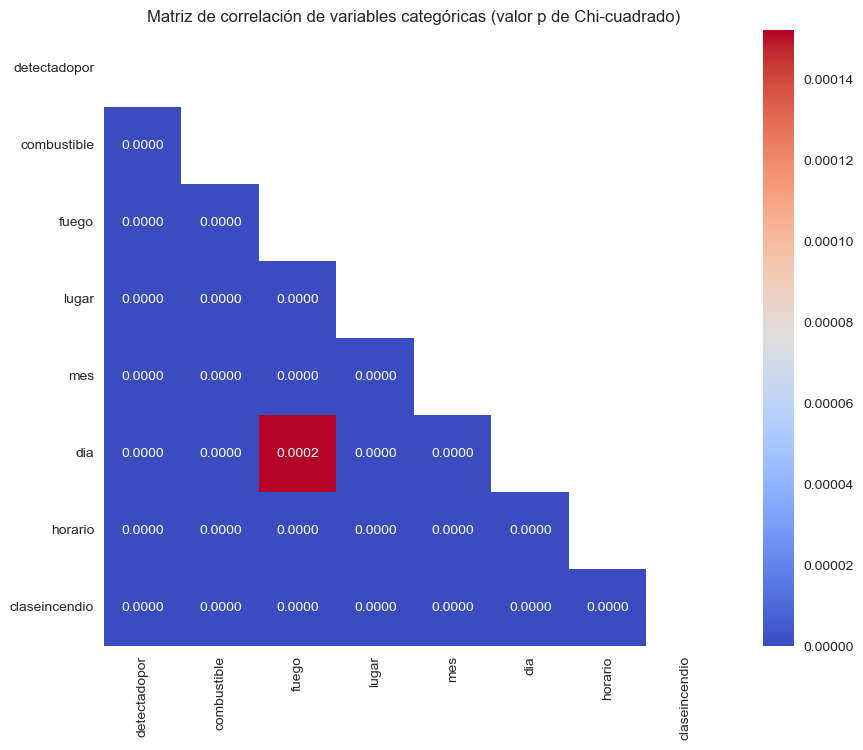

In [77]:
# Crear una matriz vacía para almacenar los valores p
matriz_pvalor = np.zeros((len(categoricas), len(categoricas)))

# Estilo
plt.style.use('seaborn-v0_8-white') 

# Calcular el test de Chi-cuadrado entre cada par de variables
for i in range(len(categoricas)):
    for j in range(len(categoricas)):
        if i != j:
            # Crear una tabla de contingencia entre las dos variables
            tabla_contingencia = pd.crosstab(bdif[categoricas[i]], bdif[categoricas[j]])

            # Aplicar el test de Chi-cuadrado
            chi2, p_value, dof, expected = stats.chi2_contingency(tabla_contingencia)

            # Guardar el valor p en la matriz
            matriz_pvalor[i, j] = p_value
        else:
            matriz_pvalor[i, j] = np.nan  # Evitar comparación con sí misma

# Crear un DataFrame para mostrar la matriz de valores p
dfpvalor = pd.DataFrame(matriz_pvalor, index=categoricas, columns=categoricas)

# Enmascarar la parte superior de la matriz para evitar mostrar la diagonal superior
mask = np.triu(np.ones_like(dfpvalor, dtype=bool), k=1)

# Visualizar la matriz de valores p
plt.figure(figsize=(10, 8))
sns.heatmap(dfpvalor, annot=True, cmap='coolwarm', fmt='.4f', mask=mask)
plt.title('Matriz de correlación de variables categóricas (valor p de Chi-cuadrado)')
plt.show()

**Graficos de barras agrupadas con respecto a los tipos de incendios**

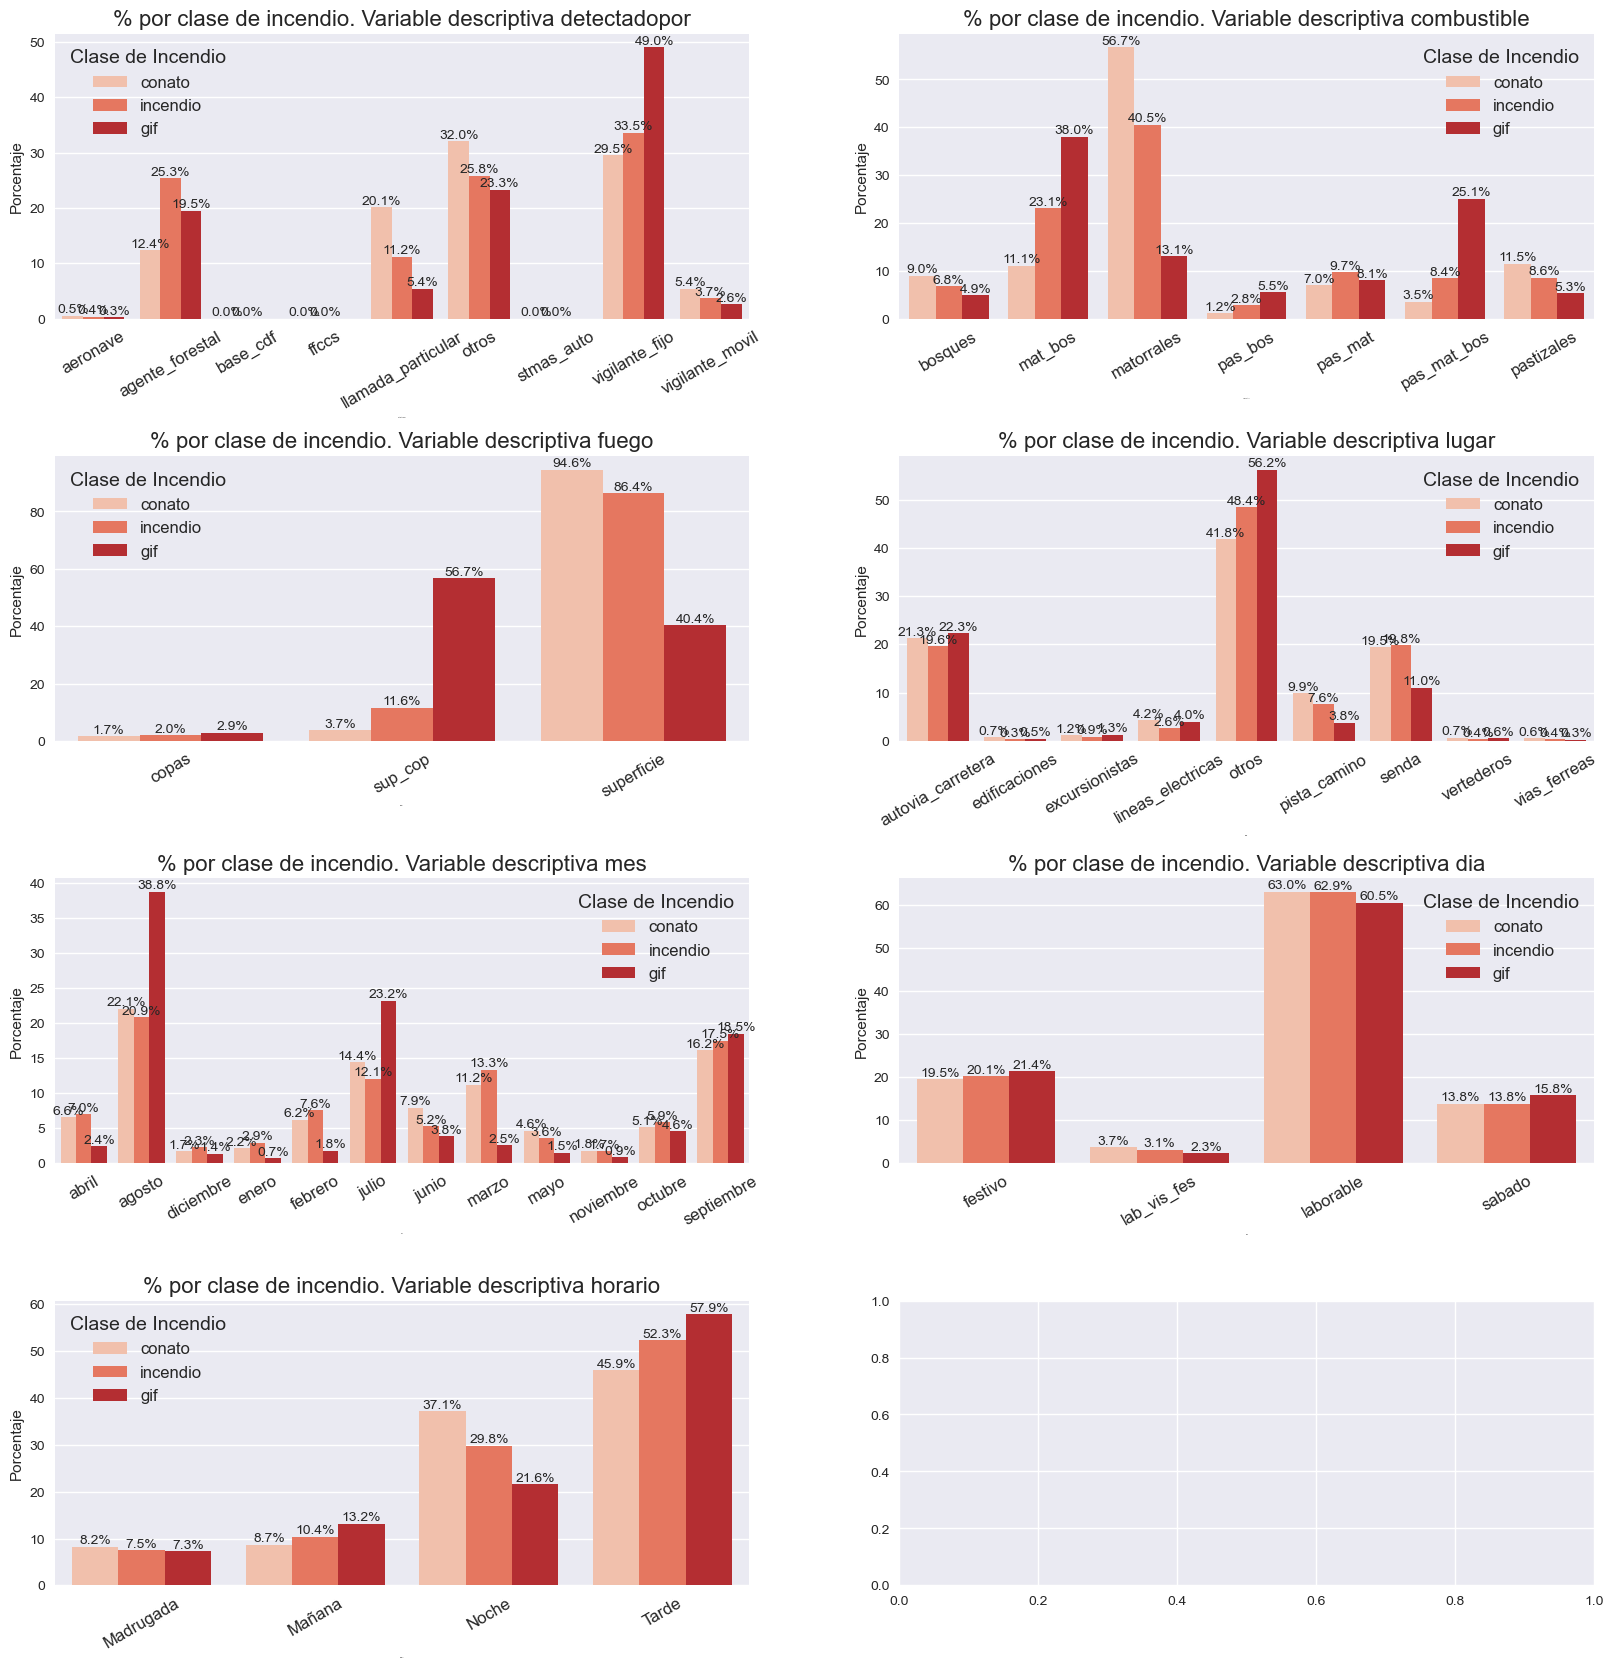

In [78]:
# Estilo
plt.style.use("seaborn-v0_8")

# Configuración del grid
fig, axes = plt.subplots(4, 2, figsize=(18, 18))
fig.tight_layout(pad=8.0)

# Iteramos por las variables categóricas
for i, col in enumerate(['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']):
    ax = axes[i // 2, i % 2]  # Posición en el grid
    
    # Calcular el porcentaje por clase de incendio para cada categoría
    tabla_frecuencia = pd.crosstab(bdif[col], bdif['claseincendio'], normalize='columns') * 100
    tabla_frecuencia = tabla_frecuencia.reset_index().melt(id_vars=col, var_name='ClaseIncendio', value_name='Porcentaje')
    
    # Graficar barras agrupadas
    sns.barplot(
        data=tabla_frecuencia, 
        x=col, 
        y='Porcentaje', 
        hue='ClaseIncendio',
        hue_order=['conato', 'incendio', 'gif'],
        ax=ax, 
        palette='Reds'
    )
    
    # Ajustes estéticos
    ax.set_title(f'% por clase de incendio. Variable descriptiva {col}', fontsize=16)
    ax.set_xlabel(col, fontsize=0)
    ax.tick_params(axis='x', rotation=30, labelsize=12)
    ax.legend(title='Clase de Incendio', fontsize=12, title_fontsize=14, loc='best')
    
    # Añadir los porcentajes sobre las barras
    for p in ax.patches:
        if p.get_height() > 0:  # Evitar etiquetas en barras de altura cero
            ax.annotate(
                f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='bottom', 
                fontsize=10
            )

# Mostrar el gráfico
plt.show()